In [1]:
using LinearAlgebra
using SparseArrays
using ArnoldiMethod
using PyPlot

using Combinatorics
using BenchmarkTools

In [7]:
A = [1 2 3]
B = [4 5 6]

hcat(A',B',A')

3×3 Matrix{Int64}:
 1  4  1
 2  5  2
 3  6  3

In [32]:
A = [5 0 0; 4 1 0 ; 4 0 1 ]
x = eachrow(A)

B = Vector{Tuple{Int64, Int64, Float64}}(tuple.(eachcol(A)...))

3-element Vector{Tuple{Int64, Int64, Float64}}:
 (5, 0, 0.0)
 (4, 1, 0.0)
 (4, 0, 1.0)

# Exact diagonalization Bose-Fermi Hubbard

Permutations of ones and zeros:

3.709 ms (86200 allocations: 4.44 MiB)

Bose basis restricted to maximum one particle per site:

34.867 μs (936 allocations: 246.73 KiB)

In [2]:
BoseBasisSize(L::Int, N::Int)  = binomial(L+N-1, N)
FermiBasisSize(L::Int, N::Int) = binomial(L, N)

function MultipleOccupancy(x::Vector{Int}, N_max::Int)::Bool
    for n in x
        if n > N_max
            return false
        end
    end
    return true
end

function GenerateBasis(L::Int, N::Int, N_max::Int = N)::Tuple{Vector{Vector{Int64}}, BitVector}
    Basis = Array{Vector{Int}}(undef, BoseBasisSize(L, N))
    
    n = 1
    x = zeros(Int, L)
    x[1] = N
    Basis[n] = copy(x)
    
    while x[L] ≠ N
        
        n += 1
        x[L] = N
        
        kk = L-1
        while x[kk] == 0
            kk -= 1
        end
        
        x[kk] -= 1
        x[kk+1] = N-sum(x[1:kk])
        x[kk+2:L] .= 0
        Basis[n] = copy(x)
    end

    if N_max < N
        T = MultipleOccupancy.(Basis, N_max)
        filter!(x->MultipleOccupancy(x, N_max), Basis)
        return Basis, T
    else
        T = MultipleOccupancy.(Basis, N)
        return Basis, T
    end
end

function BasisTransformation(x::Vector{TV}, T::BitVector)::Vector{TV} where TV
    y = Array{TV}(undef, length(T))
    jj = 0
    for ii in eachindex(T)
        if T[ii]
            jj += 1
            y[ii] = x[jj]
        else
            y[ii] = 0
        end
    end
    return y
end

BasisTransformation (generic function with 1 method)

In [3]:
function GenerateBFBasis(L::Int, NB::Int, NF::Int; NB_max::Int = NB, restricted::Bool = false)::Tuple{Vector{Vector{Int64}}, BitVector}
    BoseBasis, TB = GenerateBasis(L, NB, NB_max)
    FermiBasis, TF = GenerateBasis(L, NF, 1)
    BoseFermiBasis = Array{Vector{Int}}(undef, length(BoseBasis)*length(FermiBasis))

    n = 0
    for xB in BoseBasis
        for xF in FermiBasis
            n += 1
            BoseFermiBasis[n] = (NB_max+1)*xF+xB  # nF*(NBmax+1)+nB is a one-to-one mapping from (nF,nB) to integers
        end
    end

    if restricted
        TBF = MultipleOccupancy.(BoseFermiBasis, NB_max+1)
        filter!(x->MultipleOccupancy(x, NB_max+1), BoseFermiBasis)
        return BoseFermiBasis, TBF
    else
        TBF = MultipleOccupancy.(BoseFermiBasis, 2*NB_max+1)
        return BoseFermiBasis, TBF
    end
end

GenerateBFBasis (generic function with 1 method)

In [4]:
function GenerateTag(x::Vector{Int})::Float64
    T = 0
    for ii in eachindex(x)
        T += log((100*ii+3))*x[ii]
    end
    return T
end

function AddTerm!(X::Vector{Int}, Y::Vector{Int}, V::Vector{Float64}, x::Int, y::Int, v::Float64)
    push!(X, x)
    push!(Y, y)
    push!(V, v)
end

function AddBosonHopping!(X::Vector{Int}, Y::Vector{Int}, V::Vector{Float64}, n::Int, x::Vector{Int}, ii::Int, jj::Int; Tags::Vector{Float64}, t::Float64, NB_max::Int)
    y = copy(x)
    y[ii] -= 1
    y[jj] += 1
    Tag = GenerateTag(y)
    m_list = findall(T -> T == Tag, Tags)
    for m in m_list
        AddTerm!(X, Y, V, n, m, -t*√((x[ii]%(NB_max+1))*(y[jj]%(NB_max+1))))
    end
end

function AddFermionHopping!(X::Vector{Int}, Y::Vector{Int}, V::Vector{Float64}, n::Int, x::Vector{Int}, ii::Int, jj::Int; Tags::Vector{Float64}, t::Float64, NB_max::Int)
    y = copy(x)
    y[ii] -= NB_max+1
    y[jj] += NB_max+1
    Tag = GenerateTag(y)
    m_list = findall(T -> T == Tag, Tags)
    for m in m_list
        AddTerm!(X, Y, V, n, m, -t)
    end
end

function AddBosonInteraction!(X::Vector{Int}, Y::Vector{Int}, V::Vector{Float64}, n::Int, x::Vector{Int}, ii::Int; UBB::Float64, NB_max::Int)
    AddTerm!(X, Y, V, n, n, UBB*(x[ii]%(NB_max+1))*((x[ii]%(NB_max+1)-1)))
end

function AddBoseFermiInteraction!(X::Vector{Int}, Y::Vector{Int}, V::Vector{Float64}, n::Int, x::Vector{Int}, ii::Int; UBF::Float64, NB_max::Int)
    AddTerm!(X, Y, V, n, n, UBF*(x[ii]%(NB_max+1))*(x[ii]÷(NB_max+1)))
end

AddBoseFermiInteraction! (generic function with 1 method)

In [28]:
A = (1,2,0.0)
X = fill(A, 10)
X

10-element Vector{Tuple{Int64, Int64, Float64}}:
 (1, 2, 0.0)
 (1, 2, 0.0)
 (1, 2, 0.0)
 (1, 2, 0.0)
 (1, 2, 0.0)
 (1, 2, 0.0)
 (1, 2, 0.0)
 (1, 2, 0.0)
 (1, 2, 0.0)
 (1, 2, 0.0)

In [5]:
function BoseFermiHubbard(Basis::Vector{Vector{Int64}}, t::Float64, UBB::Float64, UBF::Float64, NB_max::Int, pB::Bool=false, pF::Bool=false)::SparseMatrixCSC{Float64, Int64}
    D = length(Basis)
    Tags = GenerateTag.(Basis)
    
    X = Vector{Int}()
    Y = Vector{Int}()
    V = Vector{Float64}()

    for (n, x) in enumerate(Basis)
        L = length(x)

        for ii in 1:L-1
            AddBosonHopping!(X, Y, V, n, x, ii, ii+1; Tags, t, NB_max)
            AddBosonHopping!(X, Y, V, n, x, ii+1, ii; Tags, t, NB_max)
            
            AddFermionHopping!(X, Y, V, n, x, ii, ii+1; Tags, t, NB_max)
            AddFermionHopping!(X, Y, V, n, x, ii+1, ii; Tags, t, NB_max)
        end
        if pB
            AddBosonHopping!(X, Y, V, n, x, 1, L; Tags, t, NB_max)
            AddBosonHopping!(X, Y, V, n, x, L, 1; Tags, t, NB_max)
        end
        if pF
            AddFermionHopping!(X, Y, V, n, x, 1, L; Tags, t, NB_max)
            AddFermionHopping!(X, Y, V, n, x, L, 1; Tags, t, NB_max)
        end

        for ii in 1:L
            AddBosonInteraction!(X, Y, V, n, x, ii; UBB, NB_max)
            AddBoseFermiInteraction!(X, Y, V, n, x, ii; UBF, NB_max)
        end
    end

    H = sparse(X, Y, V, D, D)
    return H
end

BoseFermiHubbard (generic function with 3 methods)

In [6]:
function Diagonalize(HBF::SparseMatrixCSC{Float64, Int64}; M::Int=1, tol::Float64=1e-8, mode=:Sparse)::Tuple{Vector{Float64}, Matrix{Float64}}
    if mode == :Sparse
        decomp, history = partialschur(HBF, nev=M, tol=tol, which=SR())
        E = Real.(decomp.eigenvalues)
        Ψ = Matrix(decomp.Q)
        return E, Ψ
    elseif mode == :Full
        full_HBF = Symmetric(Matrix(HBF))
        E, Ψ = eigen(full_HBF)
        return E, Ψ
    end
end

Diagonalize (generic function with 1 method)

In [7]:
function GetDensities(Basis::Vector{Vector{Int64}}, ψ::Vector{T}, NB_max::Int)::Tuple{Vector{Float64}, Vector{Float64}} where T
    L = length(Basis[1])
    nᵇ = zeros(Float64, L)
    nᶠ = zeros(Float64, L)
    for (ii, x) in enumerate(Basis)
        nᵇ += @.(x%(NB_max+1))*ψ[ii]^2
        nᶠ += @.(x÷(NB_max+1))*ψ[ii]^2
    end
    return nᵇ, nᶠ
end

GetDensities (generic function with 1 method)

# Test

In [8]:
L = 8
NB = L
NF = 2

t = 1.
UBB = 1.
UBF = 1.

pB = true
pF = false

M = 2*L
tol = 1e-8

Basis, T = GenerateBFBasis(L, NB, NF; restricted=true)
#print(length(Basis))
HBF = BoseFermiHubbard(Basis, t, UBB, UBF, NB, pB, pF)
#println("Hilbert Space: ", length(Basis))

36036×36036 SparseMatrixCSC{Float64, Int64} with 267792 stored entries:
⎡⢿⣷⡦⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⎤
⎢⠈⢯⣻⣾⣏⠳⣤⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠈⢯⡙⠿⣧⡈⢻⡙⠦⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⢻⣦⣈⠻⣦⣥⡀⠈⠻⣶⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠳⡌⠁⠻⢿⣷⡄⠀⠈⢧⠉⠳⢤⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠙⣦⡀⠀⠉⠻⣦⡄⠈⠃⠀⠀⠉⠳⣦⣤⣀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠘⢿⠦⣄⡀⠉⢿⣷⡦⢄⡀⠀⠀⠀⠉⠓⠯⣝⡒⠦⢤⣀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠈⢧⡀⠉⠀⠈⢏⠻⣦⣁⡀⠀⠀⠀⠀⠀⠀⠉⠳⣄⠀⠉⠙⠒⠦⢤⣀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠳⡄⠀⠀⠈⠁⠸⡿⣯⡄⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠈⠉⠓⠲⢤⣀⠀⎥
⎢⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠹⣦⠀⠀⠀⠀⠀⠉⢻⣶⣤⠀⠀⠀⠀⠀⠀⠀⠈⠁⠀⠀⠀⠀⠀⠀⠀⠀⠈⠉⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢻⢧⠀⠀⠀⠀⠀⠀⠛⠿⣧⡳⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⣏⢧⠀⠀⠀⠀⠀⠀⠙⠮⣿⣿⡌⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠸⡌⢧⡀⠀⠀⠀⠀⠀⠀⢦⡉⠻⣦⣘⠂⠀⢦⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢳⠀⠙⢦⡀⠀⠀⠀⠀⠀⠙⠲⠘⢿⣷⣆⠀⠈⠙⠲⣄⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⣇⠀⠀⠙⠆⠀⠀⠀⠀⠀⠠⣄⠈⠙⠻⣦⣀⠀⠀⠈⠳⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠸⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⣆⠀⠀⠘⢿⣷⣤⡀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢳⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢦⡀⠀⠀⠻⣿⣿⣐⠦⣄⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢧⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠂⠀⠀⠰⡜⠻⣦⡈⠓⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⣆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⠈⢿⣷⣤⡀⎥
⎣⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⡆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠻⠻⣦⎦

In [9]:
E, Ψ = Diagonalize(HBF; M=M, mode=:Sparse)

([-6.774705104093855, -6.753009018378824, -6.719228489652114, -6.677396662496792, -6.677351648550226, -6.633974448993164, -6.598090840386105, -6.589121997901528, -5.917092504900749, -5.8569416746992635, -5.772361550063242, -5.676415044872003, -5.674973920036934, -5.572265587588724, -5.468994825358788, -5.394730147751817], [7.477842228139825e-10 3.9081238057173175e-10 … -2.045498689010475e-9 1.2386797588567254e-9; 8.654453012731823e-9 2.7557205593712915e-9 … -2.011735704148303e-8 1.1924512132928977e-8; … ; 8.660149800842627e-9 -2.7650617607699934e-9 … -2.012447535613849e-8 -1.1938413486891343e-8; 7.501590632754322e-10 -4.037660870836286e-10 … -2.0357412992911565e-9 -1.2260936167393165e-9])

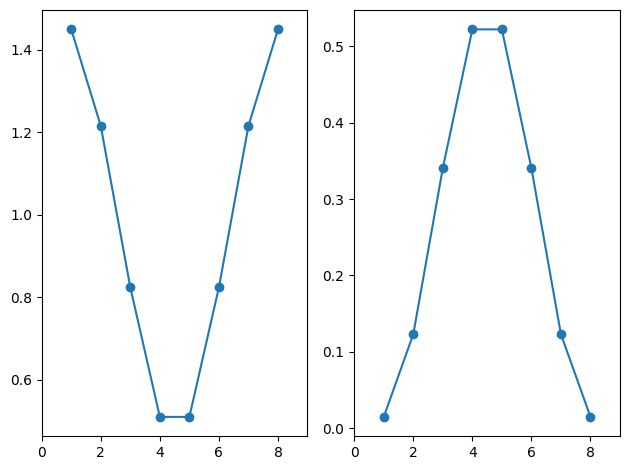

In [10]:
ψ₀ = Ψ[:,1]
nᵇ, nᶠ = GetDensities(Basis, ψ₀, NB)
fig, axs = subplots(1, 2)
axs[1].plot(1:L, nᵇ, marker="o")
axs[2].plot(1:L, nᶠ, marker="o")
axs[1].set_xlim(0,L+1)
axs[2].set_xlim(0,L+1)
tight_layout()

# Closed-open

In [9]:
collect(LinRange(0,5,21))

21-element Vector{Float64}:
 0.0
 0.25
 0.5
 0.75
 1.0
 1.25
 1.5
 1.75
 2.0
 2.25
 2.5
 2.75
 3.0
 3.25
 3.5
 3.75
 4.0
 4.25
 4.5
 4.75
 5.0

In [111]:
L = 5
NB = L
NF = 2

t = 1.
UBB_list = collect(LinRange(0,5,20))
UBF = 1.

pB = true
pF = false

M = 2*L
tol = 1e-8

Basis, T = GenerateBFBasis(L, NB, NF; restricted=true)

E_list = []
nᵇ_list = []
nᶠ_list = []
for UBB in UBB_list
    HBF = BoseFermiHubbard(Basis, t, UBB, UBF, NB, pB, pF)
    E, Ψ = Diagonalize(HBF; M=M, mode=:Full)
    nᵇ, nᶠ = GetDensities(Basis, Ψ[:,6], NB)
    append!(E_list, [E])
    append!(nᵇ_list, [nᵇ])
    append!(nᶠ_list, [nᶠ])
end

E_list = reduce(vcat,transpose.(E_list))
nᵇ_list = reduce(vcat,transpose.(nᵇ_list))
nᶠ_list = reduce(vcat,transpose.(nᶠ_list))
println()

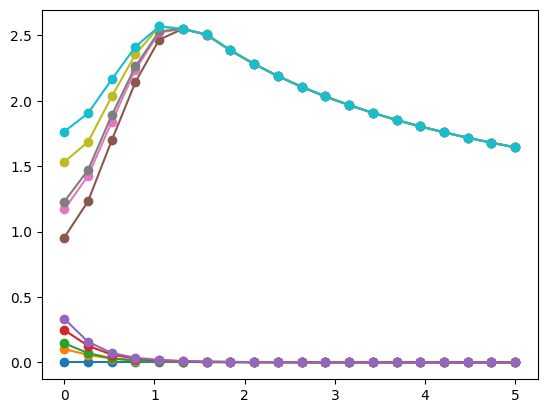

In [114]:
for n in 1:2*L
    plot(UBB_list, E_list[:,n]-E_list[:,1], marker="o")
end

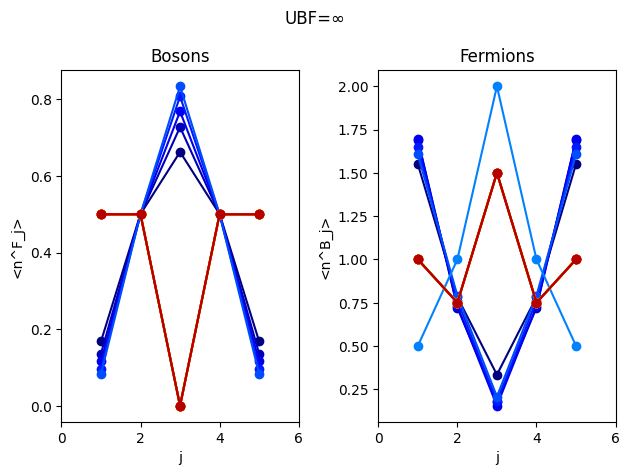

In [113]:
fig, axs = subplots(1, 2)

cm = get_cmap(:jet)
colorrange = collect(0:length(UBB_list)-1)./length(UBB_list)
for ii in eachindex(UBB_list)
    axs[1].plot(1:L, nᶠ_list[ii,:], marker="o", color=cm(colorrange[ii]))
    axs[2].plot(1:L, nᵇ_list[ii,:], marker="o", color=cm(colorrange[ii]))
end

axs[1].set_xlim(0,L+1)
axs[2].set_xlim(0,L+1)
axs[1].set_title("Bosons")
axs[2].set_title("Fermions")
axs[1].set_ylabel("<n^F_j>")
axs[2].set_ylabel("<n^B_j>")
axs[1].set_xlabel("j")
axs[2].set_xlabel("j")
fig.suptitle("UBF=∞")
tight_layout()

# Semi periodic

In [86]:
L = 6
NB = L
NF = 2
t = 1
UBB_list = collect(LinRange(0,5,50))
UBF = 0
pB = true
pF = false

M=3*L
tol=1e-8


BFLabels = BoseFermiLabels(L, NB, NF, true)
println("Hilbert Space: ", length(BFLabels))

E_list = []
nᵇ_list = []
nᶠ_list = []

for UBB in UBB_list
    HBF = BoseFermiHubbard(BFLabels, t, UBB, UBF, pB, pF)
    decomp, history = partialschur(HBF, nev=M, tol=tol, which=SR())
    E = Real.(decomp.eigenvalues)
    ψ₀ = decomp.Q[:,1]
    nᶠ, nᵇ = GetDensities(BFLabels, ψ₀)
    append!(E_list, [E])
    append!(nᵇ_list, [nᵇ])
    append!(nᶠ_list, [nᶠ])
end

E_list = reduce(vcat,transpose.(E_list))
nᵇ_list = reduce(vcat,transpose.(nᵇ_list))
nᶠ_list = reduce(vcat,transpose.(nᶠ_list))
println()

LoadError: UndefVarError: `BoseFermiLabels` not defined

In [ ]:

    plot(UBB_list, E_list[:,n]-E_list[:,1], marker="o", color="tab:blue")
end
for n in L+1:2*L
    plot(UBB_list, E_list[:,n]-E_list[:,1], marker="o", color="tab:orange")
end
for n in 2*L+1:3*L
    plot(UBB_list, E_list[:,n]-E_list[:,1], marker="o", color="tab:red")
end
title("UBF=∞")
xlabel("UBB")
ylabel("E-E₀")

# Semi periodic 2

In [ ]:
L = 5
NB = L
NF = 2
t = 1
UBB_list = collect(LinRange(0,5,50))
UBF = 0
pB = false
pF = false

M=3*L
tol=1e-8


BFLabels = BoseFermiLabels(L, NB, NF, true)
println("Hilbert Space: ", length(BFLabels))

E_list = []
nᵇ_list = []
nᶠ_list = []

for UBB in UBB_list
    HBF = BoseFermiHubbard(BFLabels, t, UBB, UBF, pB, pF)
    HBF = Matrix(HBF)
    E = real.(eigvals(HBF))
    append!(E_list, [E])
end
E_list = reduce(vcat,transpose.(E_list))

In [ ]:
for n in 1:L
    plot(UBB_list, E_list[:,n]-E_list[:,1], marker="o", color="tab:blue")
end
for n in L+1:2*L
    plot(UBB_list, E_list[:,n]-E_list[:,1], marker="o", color="tab:orange")
end
for n in 2*L+1:3*L
    plot(UBB_list, E_list[:,n]-E_list[:,1], marker="o", color="tab:red")
end
title("UBF=∞")
xlabel("UBB")
ylabel("E-E₀")

## To the limit

In [ ]:
L = 5
NB = L
NF = 2
t = 1
UBB = 10
UBF_list = collect(LinRange(0,200,20))
pB = true
pF = false

M=3*L
tol=1e-8


BFLabels = BoseFermiLabels(L, NB, NF)
println("Hilbert Space: ", length(BFLabels))

E_list = []
nᵇ_list = []
nᶠ_list = []

for UBF in UBF_list
    HBF = BoseFermiHubbard(BFLabels, t, UBB, UBF, pB, pF)
    decomp, history = partialschur(HBF, nev=M, tol=tol, which=SR())
    E = Real.(decomp.eigenvalues)
    ψ₀ = decomp.Q[:,1]
    nᶠ, nᵇ = GetDensities(BFLabels, ψ₀)
    append!(E_list, [E])
    append!(nᵇ_list, [nᵇ])
    append!(nᶠ_list, [nᶠ])
end

BFLabels = BoseFermiLabels(L, NB, NF, true)
println("Hilbert Space: ", length(BFLabels))

for UBF in [UBF_list[end]*1.1]
    HBF = BoseFermiHubbard(BFLabels, t, UBB, UBF, pB, pF)
    decomp, history = partialschur(HBF, nev=M, tol=tol, which=SR())
    E = Real.(decomp.eigenvalues)
    ψ₀ = decomp.Q[:,1]
    nᶠ, nᵇ = GetDensities(BFLabels, ψ₀)
    append!(UBF_list, UBF)
    append!(E_list, [E])
    append!(nᵇ_list, [nᵇ])
    append!(nᶠ_list, [nᶠ])
end

E_list = reduce(vcat,transpose.(E_list))
nᵇ_list = reduce(vcat,transpose.(nᵇ_list))
nᶠ_list = reduce(vcat,transpose.(nᶠ_list))
println()

In [ ]:
for n in 1:L
    plot(UBF_list, E_list[:,n]-E_list[:,1], marker="o", color="tab:blue")
end
for n in L+1:2*L
    plot(UBF_list, E_list[:,n]-E_list[:,1], marker="o", color="tab:orange")
end
for n in 2*L+1:3*L
    plot(UBF_list, E_list[:,n]-E_list[:,1], marker="o", color="tab:red")
end
title("UBB="*string(UBB))
xlabel("UBF")
ylabel("E-E₀")

In [ ]:
fig, axs = subplots(1, 2)

cm = get_cmap(:jet)
colorrange = collect(0:length(UBF_list)-1)./length(UBF_list)
for ii in 1:length(UBF_list)-1
    axs[1].plot(1:L, nᶠ_list[ii,:], marker="o", color=cm(colorrange[ii]))
    axs[2].plot(1:L, nᵇ_list[ii,:], marker="o", color=cm(colorrange[ii]))
end

axs[1].plot(1:L, nᶠ_list[end,:], marker="x", color=cm(colorrange[end]))
axs[2].plot(1:L, nᵇ_list[end,:], marker="x", color=cm(colorrange[end]))

axs[1].set_xlim(0,L+1)
axs[2].set_xlim(0,L+1)
axs[1].set_title("Bosons")
axs[2].set_title("Fermions")
axs[1].set_ylabel("<n^F_j>")
axs[2].set_ylabel("<n^B_j>")
axs[1].set_xlabel("j")
axs[2].set_xlabel("j")
fig.suptitle("UBB="*string(UBB))
tight_layout()

## Periodic

In [ ]:
L = 5
NB = L
NF = 2
t = 1
UBB_list = collect(LinRange(0,1000,50))
UBF = 0
pB = true
pF = false

M=L
tol=1e-8


BFLabels = BoseFermiLabels(L, NB, NF, true)
println("Hilbert Space: ", length(BFLabels))

E_list = []
nᵇ_list = []
nᶠ_list = []

for UBB in UBB_list
    HBF = BoseFermiHubbard(BFLabels, t, UBB, UBF, pB, pF)
    decomp, history = partialschur(HBF, nev=M, tol=tol, which=SR())
    E = real.(decomp.eigenvalues)
    ψ₀ = decomp.Q[:,1]
    nᶠ, nᵇ = GetDensities(BFLabels, ψ₀)
    append!(E_list, [E])
    append!(nᵇ_list, [nᵇ])
    append!(nᶠ_list, [nᶠ])
end

E_list = reduce(vcat,transpose.(E_list))
nᵇ_list = reduce(vcat,transpose.(nᵇ_list))
nᶠ_list = reduce(vcat,transpose.(nᶠ_list))
println()

In [ ]:
for n in 1:M
    plot(UBB_list, E_list[:,n]-E_list[:,1], marker="o")
end

title("UBF=∞")
xlabel("UBB")
ylabel("E-E₀")

In [ ]:
fig, axs = subplots(1, 2)

cm = get_cmap(:jet)
colorrange = collect(0:length(UBB_list)-1)./length(UBB_list)
for ii in 1:length(UBB_list)-1
    axs[1].plot(1:L, nᶠ_list[ii,:], marker="o", color=cm(colorrange[ii]))
    axs[2].plot(1:L, nᵇ_list[ii,:], marker="o", color=cm(colorrange[ii]))
end

axs[1].plot(1:L, nᶠ_list[end,:], marker="x", color=cm(colorrange[end]))
axs[2].plot(1:L, nᵇ_list[end,:], marker="x", color=cm(colorrange[end]))

axs[1].set_xlim(0,L+1)
axs[2].set_xlim(0,L+1)
axs[1].set_title("Bosons")
axs[2].set_title("Fermions")
axs[1].set_ylabel("<n^F_j>")
axs[2].set_ylabel("<n^B_j>")
axs[1].set_xlabel("j")
axs[2].set_xlabel("j")
fig.suptitle("UBF=∞")
tight_layout()

In [ ]:
L = 5
NB = L
NF = 2
t = 1
UBB_list = collect(LinRange(0,5,20))
UBF = 0
pB = true
pF = true

M=2*L
tol=1e-8


BFLabels = BoseFermiLabels(L, NB, NF, true)
println("Hilbert Space: ", length(BFLabels))

E_list = []
nᵇ_list = []
nᶠ_list = []

for UBB in UBB_list
    HBF = BoseFermiHubbard(BFLabels, t, UBB, UBF, pB, pF)
    decomp, history = partialschur(HBF, nev=M, tol=tol, which=SR())
    E = Real.(decomp.eigenvalues)
    ψ₀ = decomp.Q[:,1]
    nᶠ, nᵇ = GetDensities(BFLabels, ψ₀)
    append!(E_list, [E])
    append!(nᵇ_list, [nᵇ])
    append!(nᶠ_list, [nᶠ])
end

E_list = reduce(vcat,transpose.(E_list))
nᵇ_list = reduce(vcat,transpose.(nᵇ_list))
nᶠ_list = reduce(vcat,transpose.(nᶠ_list))

In [ ]:
for n in 1:M
    plot(UBB_list, E_list[:,n]-E_list[:,1], marker="o")
end

## To the limit2

In [ ]:
L = 5
NB = L
NF = 2
t = 1
UBB = 2
UBF_list = collect(LinRange(0,200,20))
pB = true
pF = false

M=3*L
tol=1e-8


BFLabels = BoseFermiLabels(L, NB, NF)
println("Hilbert Space: ", length(BFLabels))

E_list = []
nᵇ_list = []
nᶠ_list = []

for UBF in UBF_list
    HBF = BoseFermiHubbard(BFLabels, t, UBB, UBF, pB, pF)
    HBF = Matrix(HBF)
    E = real.(eigvals(HBF))
    append!(E_list, [E])
end

#BFLabels = BoseFermiLabels(L, NB, NF, true)
#println("Hilbert Space: ", length(BFLabels))

#for UBF in [UBF_list[end]*1.1]
#    HBF = BoseFermiHubbard(BFLabels, t, UBB, UBF, pB, pF)
#    HBF = Matrix(HBF)
#    E = real.(eigvals(HBF))
#    append!(E_list, [E])
#    append!(UBF_list, UBF)
#end

E_list = reduce(vcat,transpose.(E_list))
println()

In [ ]:
for n in 1:L
    plot(UBF_list, E_list[:,n]-E_list[:,1], marker="o", color="tab:blue")
end
for n in L+1:2*L
    plot(UBF_list, E_list[:,n]-E_list[:,1], marker="o", color="tab:orange")
end
for n in 2*L+1:3*L
    plot(UBF_list, E_list[:,n]-E_list[:,1], marker="o", color="tab:red")
end
title("UBB="*string(UBB))
xlabel("UBF")
ylabel("E-E₀")